In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import pickle

2024-11-20 13:09:12.544089: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Load the dataset from pickle file generated by extract_landmarks_hands.py
with open("raw_data/landmarks/word_landmarks_hand_large.pkl", "rb") as f:
    landmarks_dataset = pickle.load(f)

In [ ]:
words = [data['word'] for data in landmarks_dataset]
print(words)

In [3]:
# Step 1: Define the word list
word_list = ['WE', 'LEARN', 'TO', 'SIGN', 'NAME', 'OF', 'CUTE', 'ANIMAL', 'HIPPO', 'BEAR', 'ZEBRA', 'MOUSE', 'FOX', 'LION', 'DEER', 'RAT', 'WOLF', 'COBRA', 'OTTER', 'PEEKABOO'] #, 'BAT', 'LION', 'DEER', 'RAT', 'WOLF', 'COBRA', 'OTTER', 'PEEKABOO']

# Filter the dataset to only keep items with words in the word_list
filtered_landmarks_dataset = [data for data in landmarks_dataset if data['word'] in word_list]

# Check the filtered dataset
print([data['word'] for data in filtered_landmarks_dataset])

['LION', 'HIPPO', 'ANIMAL', 'CUTE', 'WE', 'ANIMAL', 'CUTE', 'CUTE', 'DEER', 'NAME', 'LEARN', 'CUTE', 'RAT', 'MOUSE', 'HIPPO', 'WE', 'SIGN', 'WOLF', 'WOLF', 'HIPPO', 'PEEKABOO', 'NAME', 'MOUSE', 'PEEKABOO', 'WOLF', 'LION', 'BEAR', 'CUTE', 'HIPPO', 'MOUSE', 'ZEBRA', 'NAME', 'SIGN', 'HIPPO', 'SIGN', 'CUTE', 'BEAR', 'FOX', 'RAT', 'LION', 'ZEBRA', 'LION', 'HIPPO', 'PEEKABOO', 'WOLF', 'DEER', 'HIPPO', 'FOX', 'HIPPO', 'ZEBRA', 'ANIMAL', 'RAT', 'BEAR', 'WE', 'HIPPO', 'DEER', 'LION', 'SIGN', 'WE', 'HIPPO', 'SIGN', 'BEAR', 'WOLF', 'FOX', 'TO', 'HIPPO', 'SIGN', 'ZEBRA', 'SIGN', 'FOX', 'LEARN', 'TO', 'BEAR', 'ZEBRA', 'LION', 'RAT', 'SIGN', 'TO', 'MOUSE', 'WOLF', 'RAT', 'HIPPO', 'LION', 'HIPPO', 'TO', 'SIGN', 'LION', 'WE', 'TO', 'PEEKABOO', 'TO', 'TO', 'WOLF', 'RAT', 'NAME', 'CUTE', 'PEEKABOO', 'RAT', 'PEEKABOO', 'MOUSE', 'TO', 'HIPPO', 'ZEBRA', 'ANIMAL', 'PEEKABOO', 'LION', 'CUTE', 'RAT', 'MOUSE', 'FOX', 'ANIMAL', 'SIGN', 'SIGN', 'HIPPO', 'WE', 'TO', 'BEAR', 'LEARN', 'LEARN', 'TO', 'CUTE', 'CUTE',

In [ ]:
# Save the small dataset to a file
with open("data/filtered_landmarks_dataset.pkl", "wb") as f:
    pickle.dump(filtered_landmarks_dataset, f)

In [56]:
# Create parameters for large datasets by dropping every nth frame
max_sequence_length = 100  # Set a maximum sequence length
feature_size = 126  # Assuming 21 hand landmarks * 3 = 63

# Step 2: Prepare and Preprocess the Data with Frame Subsampling
n = 3  # Use every nth frame, adjust n as needed for experimentation
X, y = [], []
for data in filtered_landmarks_dataset:
    hand_lms, word = data['hand_landmarks'], data['word']
    
    # Subsample frames
    hand_lms = hand_lms[::n]
    
    # Normalize and pad/truncate sequences to a fixed length
    sequence = np.array([np.array(landmark, dtype=np.float32) for landmark in hand_lms if len(landmark) == feature_size], dtype=np.float32)
    if len(sequence) > max_sequence_length:
        sequence = sequence[:max_sequence_length]
    else:
        pad_width = max_sequence_length - len(sequence)
        sequence = np.pad(sequence, ((0, pad_width), (0, 0)), 'constant')
    
    # Ensure the sequence has the correct shape
    X.append(sequence)
    y.append(word)

# Convert X and y to numpy arrays
X = np.array(X, dtype=np.float32)

In [5]:
# Create parameters for small datasets by using every frame
max_sequence_length = 100  # Set a maximum sequence length
feature_size = 126  # Assuming 21 hand landmarks * 3 = 63

# Step 2: Prepare and Preprocess the Data
X, y = [], []
for data in filtered_landmarks_dataset:
    hand_lms, word = data['hand_landmarks'], data['word']
    
    # Normalize and pad/truncate sequences to a fixed length
    sequence = np.array([np.array(landmark, dtype=np.float32) for landmark in hand_lms if len(landmark) == feature_size], dtype=np.float32)
    #print(sequence.shape)
    if len(sequence) > max_sequence_length:
        sequence = sequence[:max_sequence_length]
    else:
        pad_width = max_sequence_length - len(sequence)
        sequence = np.pad(sequence, ((0, pad_width), (0, 0)), 'constant')
    
    # Ensure the sequence has the correct shape
    X.append(sequence)
    y.append(word)

# Convert X and y to numpy arrays
X = np.array(X, dtype=np.float32)

In [6]:
# Check shape of X and y
print(X.shape)
print(y.shape)

(586, 100, 126)

In [7]:
# Label encoding for the words
y = np.array(y).tolist()  # Convert numpy array to list of strings
y = ["Unknown" if (not isinstance(label, str) or len(label) == 0 or pd.isna(label)) else str(label) for label in y] # Ensure all labels are strings
label_encoder = tf.keras.preprocessing.text.Tokenizer()
label_encoder.fit_on_texts(y)
y = label_encoder.texts_to_sequences(y)
y = [label[0] for label in y]  # Flatten the list of lists
y = tf.keras.utils.to_categorical(y, num_classes=len(label_encoder.word_index) + 1)

In [8]:
from collections import Counter

# Extract all words (labels) from the dataset
all_words = [data['word'] for data in filtered_landmarks_dataset]

# Count occurrences of each word
word_counts = Counter(all_words)

# Print the counts for each word
for word, count in word_counts.items():
    print(f"{word}: {count}")


LION: 31
HIPPO: 62
ANIMAL: 31
CUTE: 62
WE: 31
DEER: 30
NAME: 32
LEARN: 31
RAT: 30
MOUSE: 31
SIGN: 31
WOLF: 31
PEEKABOO: 32
BEAR: 30
ZEBRA: 31
FOX: 31
TO: 29


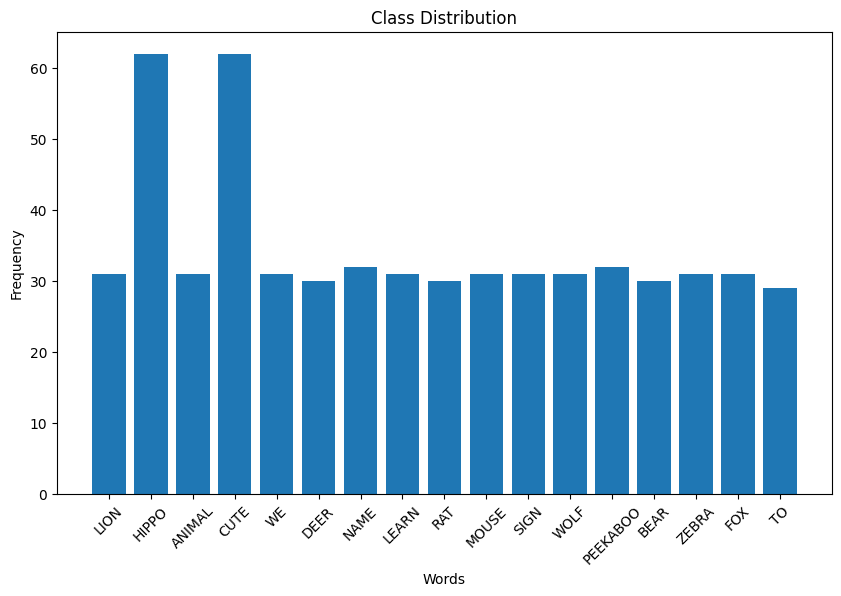

In [9]:
import matplotlib.pyplot as plt

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(word_counts.keys(), word_counts.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Step 3: Built and train the CNN model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 4: Evaluate the model
model = tf.keras.models.load_model("models/production_model/sign_language_model.keras")

4/4 [==============================] - 1s 75ms/step
Accuracy: 0.80


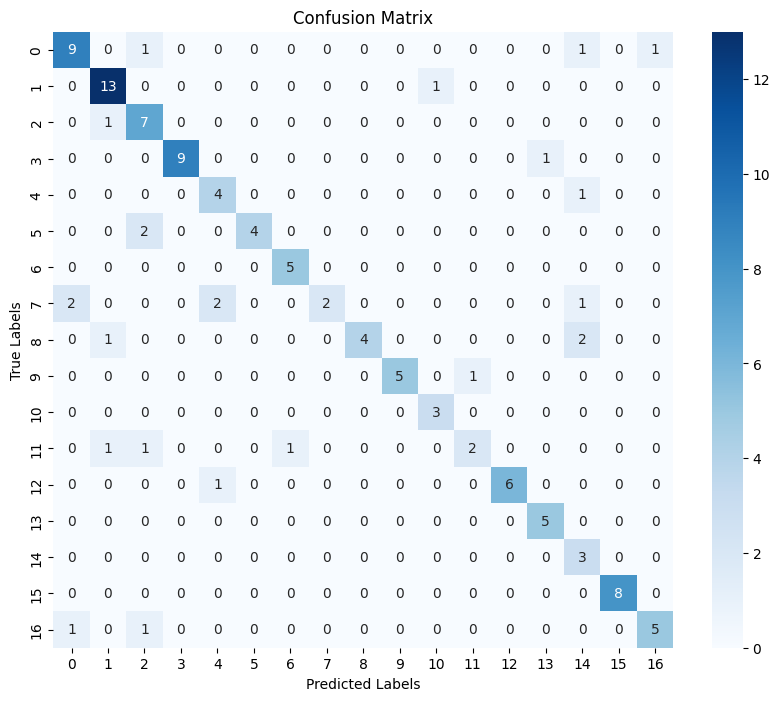

In [21]:
# Evaluate on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Step 4: Real-time classification

import cv2
import numpy as np
import imageio
import mediapipe as mp
import tensorflow as tf

# Initialize MediaPipe modules for hand detection
hands = mp.solutions.hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
drawing_utils = mp.solutions.drawing_utils

# Parameters
max_sequence_length = 100  # Set a maximum sequence length
feature_size = 126  # Assuming 21 hand landmarks * 3 = 63

# Real-time classification function
def real_time_classification_gif(video_path, output_gif_path):
    cap = cv2.VideoCapture(video_path)
    hand_landmarks_list = []
    frames = []

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # Convert frame to RGB for MediaPipe processing
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process hand landmarks
        hand_results = hands.process(frame_rgb)
        hand_landmarks = []
        if hand_results.multi_hand_landmarks:
            for hand_landmarks_obj in hand_results.multi_hand_landmarks:
                # Extract x, y, z coordinates for each landmark
                hand_landmarks.extend([lm.x for lm in hand_landmarks_obj.landmark])
                hand_landmarks.extend([lm.y for lm in hand_landmarks_obj.landmark])
                hand_landmarks.extend([lm.z for lm in hand_landmarks_obj.landmark])
            # If only one hand is detected, fill the rest with 63 zeros
            if len(hand_results.multi_hand_landmarks) == 1:
                hand_landmarks.extend([0] * (21 * 3))

            # Draw hand landmarks on the frame
            for hand_landmarks_obj in hand_results.multi_hand_landmarks:
                drawing_utils.draw_landmarks(frame, hand_landmarks_obj, mp.solutions.hands.HAND_CONNECTIONS)
                
        else:
            # Fill with 126 zeros if no hands are detected
            hand_landmarks = [0] * (21 * 3 * 2)

        hand_landmarks_list.append(hand_landmarks)

        # Show the frame with landmarks
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Save frame for GIF creation

        cv2.imshow('Video with Landmarks', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Prepare the sequence for prediction
    sequence = np.array([np.array(landmark, dtype=np.float32) for landmark in hand_landmarks_list if len(landmark) == feature_size], dtype=np.float32)
    if len(sequence) > max_sequence_length:
        sequence = sequence[:max_sequence_length]
    else:
        pad_width = max_sequence_length - len(sequence)
        sequence = np.pad(sequence, ((0, pad_width), (0, 0)), 'constant')

    # Predict the word
    sequence = np.expand_dims(sequence, axis=0)  # Add batch dimension
    prediction = model.predict(sequence)
    predicted_label = np.argmax(prediction, axis=-1)

    # Convert label index to word
    label_encoder = tf.keras.preprocessing.text.Tokenizer()
    label_encoder.fit_on_texts([data['word'] for data in landmarks_dataset])
    word_index = label_encoder.index_word
    predicted_word = word_index.get(predicted_label[0], "Unknown")

    # Add the predicted word to each frame and save as a GIF
    gif_frames = []
    for frame in frames:
        frame_with_text = frame.copy()
        cv2.putText(frame_with_text, f'Predicted Word: {predicted_word}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        gif_frames.append(frame_with_text)

    # Save as GIF
    imageio.mimsave(output_gif_path, gif_frames, fps=10)

    return predicted_word


In [ ]:
video_path = '../local_directory/428654908524865-BABY 2.mp4'
predicted_word = real_time_classification_gif(video_path, 'output_video.gif')
print(f'Predicted Word: {predicted_word}')